In [1]:
import json
import os
import argparse

import numpy as np
import random
import torch
from torch import nn, optim
from tqdm.auto import tqdm

from pathlib import Path
from torch.utils.data import DataLoader, Subset
import sys
sys.path.append('../../lib/exlib/src')
from exlib.modules.sop import SOPImageCls, SOPConfig, get_chained_attr
from exlib.datasets.cosmogrid import CosmogridDataset, CNNModel

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 42
if SEED != -1:
    # Torch RNG
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # Python RNG
    np.random.seed(SEED)
    random.seed(SEED)

In [3]:
# model paths
backbone_model_name = '../../data/cosmogrid/CNN_mass_maps.pth'

# data paths
TRAIN_DATA_DIR = '../../data/cosmogrid'
VAL_DATA_DIR = '../../data/cosmogrid'
mask_path = '../../data/cosmogrid/masks/X_maps_Cosmogrid_100k_watershed_diagonal.npy'

# training args
batch_size = 16
lr = 0.0005
num_epochs = 20
warmup_steps = 2000
mask_batch_size = 64

# experiment args
exp_dir = '../../exps/cosmogrid_4h/best'
os.makedirs(exp_dir, exist_ok=True)
output_dirname = os.path.join(exp_dir, 'val_results')
os.makedirs(output_dirname, exist_ok=True)

In [4]:
config = SOPConfig(os.path.join(exp_dir, 'config.json'))

backbone_model = CNNModel(config.num_labels)
state_dict = torch.load(backbone_model_name)
backbone_model.load_state_dict(state_dict=state_dict)
processor = None

In [5]:
def mask_transform(mask):
    seg_mask_cut_off = config.num_masks_max
    # Preprocess the mask using the ViTImageProcessor
    if len(mask.shape) == 2 and mask.dtype == torch.bool:
        mask_dim1, mask_dim2 = mask.shape
        mask = mask.unsqueeze(0).expand(3, 
                                        mask_dim1, 
                                        mask_dim2).float()
        if processor is not None:
            inputs = processor(mask, 
                            do_rescale=False, 
                            do_normalize=False,
                            return_tensors='pt')
            # (1, 3, 224, 224)
            return inputs['pixel_values'][0][0]
        else:
            return mask
    else: # len(mask.shape) == 3
        if mask.dtype != torch.bool:
            if len(mask.shape) == 2:
                mask = mask.unsqueeze(0)
            mask = convert_idx_masks_to_bool(mask)
        bsz, mask_dim1, mask_dim2 = mask.shape
        mask = mask.unsqueeze(1).expand(bsz, 
                                        3, 
                                        mask_dim1, 
                                        mask_dim2).float()

        if bsz < seg_mask_cut_off:
            repeat_count = seg_mask_cut_off // bsz + 1
            mask = torch.cat([mask] * repeat_count, dim=0)

        # add additional mask afterwards
        mask_sum = torch.sum(mask[:seg_mask_cut_off - 1], dim=0, keepdim=True).bool()
        if False in mask_sum:
            mask = mask[:seg_mask_cut_off - 1]
            compensation_mask = (1 - mask_sum.int()).bool()
            mask = torch.cat([mask, compensation_mask])
        else:
            mask = mask[:seg_mask_cut_off]

        if processor is not None:
            inputs = processor(mask, 
                            do_rescale=False, 
                            do_normalize=False,
                            return_tensors='pt')
            
            return inputs['pixel_values'][:,0]
        else:
            return mask[:,0]
        
def convert_idx_masks_to_bool(masks):
    """
    input: masks (1, img_dim1, img_dim2)
    output: masks_bool (num_masks, img_dim1, img_dim2)
    """
    unique_idxs = torch.sort(torch.unique(masks)).values
    idxs = unique_idxs.view(-1, 1, 1)
    broadcasted_masks = masks.expand(unique_idxs.shape[0], 
                                     masks.shape[1], 
                                     masks.shape[2])
    masks_bool = (broadcasted_masks == idxs)
    return masks_bool

In [6]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


# Load the dataset
train_size, val_size = -1, -1
# train_size = 100
# val_size = 100
train_dataset = CosmogridDataset(data_dir=TRAIN_DATA_DIR, split='train', data_size=train_size,
                                 mask_path=mask_path, mask_transform=mask_transform)
val_dataset = CosmogridDataset(data_dir=TRAIN_DATA_DIR, split='val', data_size=train_size,
                                 mask_path=mask_path, mask_transform=mask_transform)

# Create a DataLoader to batch and shuffle the data
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# samples used for training: 80000
# samples used for validation: 10000
# samples used for testing: 10000
# total samples: 100000
x shape (80000, 66, 66) (10000, 66, 66) (10000, 66, 66)
y shape (80000, 6) (10000, 6) (10000, 6)
masks shape (80000, 66, 66) (10000, 66, 66) (10000, 66, 66)
-- ALL --
max 0.7257571922558966
min -0.034935039865926346
-- SPLIT train --
max 0.7257571922558966
min -0.034935039865926346
Finished loading 80000 train images ... 
# samples used for training: 80000
# samples used for validation: 10000
# samples used for testing: 10000
# total samples: 100000
x shape (80000, 66, 66) (10000, 66, 66) (10000, 66, 66)
y shape (80000, 6) (10000, 6) (10000, 6)
masks shape (80000, 66, 66) (10000, 66, 66) (10000, 66, 66)
-- ALL --
max 0.6323861033355062
min -0.031224769235240986
-- SPLIT val --
max 0.6323861033355062
min -0.031224769235240986
Finished loading 10000 val images ... 


In [7]:
backbone_model = backbone_model.to(device)
class_weights = get_chained_attr(backbone_model, config.finetune_layers[0]).weight #.clone().to(device)
class_weights.shape
model = SOPImageCls(config, backbone_model) #, class_weights=class_weights, projection_layer=None)
model_state_dict = torch.load(os.path.join(exp_dir, 'checkpoint.pth'), map_location=device)['model']
model.load_state_dict(model_state_dict)
model = model.to(device)
model.eval();

deep copy class weights


In [8]:
from tqdm.auto import tqdm

iter_val_dataloader = iter(val_dataloader)
# for _ in tqdm(range(100)):
batch = next(iter_val_dataloader)

inputs, labels, masks, masks_i = batch
inputs = inputs.to(device, dtype=torch.float)
labels = labels.to(device, dtype=torch.float)
masks = masks.to(device)


with torch.no_grad():
    outputs = model(inputs, segs=masks, mask_batch_size=mask_batch_size, return_tuple=True)
    original_logits = backbone_model(inputs).logits


/opt/conda/envs/rapids/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [9]:
outputs._fields

('logits',
 'logits_all',
 'pooler_outputs_all',
 'masks',
 'mask_weights',
 'attributions',
 'attributions_max',
 'attributions_all',
 'flat_masks',
 'grouped_attributions')

In [12]:
outputs.masks.shape, outputs.mask_weights.shape, outputs.attributions.shape

(torch.Size([16, 800, 66, 66]),
 torch.Size([16, 800, 2]),
 torch.Size([16, 1, 66, 66]))

In [13]:
logits = outputs.logits
logits_all = outputs.logits_all
masks = outputs.masks
mask_weights = outputs.mask_weights
attributions = outputs.attributions

In [14]:
criterion = nn.MSELoss(reduction='none')

loss_sop = criterion(logits, labels)
loss_original = criterion(original_logits, labels)

In [15]:
bsz, num_masks, num_labels = logits_all.shape

losses = criterion(logits_all.reshape(-1, model.config.num_labels), 
                 labels.unsqueeze(1).expand(bsz, 
                                            num_masks, 
                                            num_labels).reshape(-1, num_labels))
losses = losses.reshape(logits_all.shape)

In [16]:
i = 0
masks_used = masks[i][mask_weights[i].sum(-1).bool()]  # get masks that are used for any class
mask_weights_used = mask_weights[i][mask_weights[i].sum(-1).bool()]
logits_used = logits_all[i][mask_weights[i].sum(-1).bool()]
losses_used = losses[i][mask_weights[i].sum(-1).bool()]

In [17]:
unique_masks_used, reverse_indices, counts = torch.unique(masks_used, 
                                                        dim=0, 
                                                        return_inverse=True, 
                                                        return_counts=True)
indices = []
reverse_indices = reverse_indices.cpu().numpy().tolist()

for j in range(len(counts)):
    indices.append(reverse_indices.index(j))

unique_mask_weights_used = mask_weights_used[indices] * counts.view(-1, 1)
unique_logits_used = logits_used[indices]
unique_losses_used = losses_used[indices]

In [18]:
entry = {'image': inputs[i],
         'original_logits': original_logits[i],
        'logits': logits[i],
        'unique_logits_used': unique_logits_used,
        'masks': masks[i],
        'unique_masks_used': unique_masks_used,
        'unique_mask_weights_used': unique_mask_weights_used,
        'unique_losses_used': unique_losses_used,
        'label': labels[i],
        'counts': counts,
        'num_labels': model.config.num_labels}


In [19]:
entry

{'image': tensor([[[-0.0038, -0.0044, -0.0079,  ...,  0.0032, -0.0029, -0.0011],
          [-0.0005, -0.0063, -0.0056,  ...,  0.0062,  0.0031,  0.0016],
          [ 0.0036, -0.0004,  0.0004,  ..., -0.0022,  0.0012, -0.0012],
          ...,
          [ 0.0084,  0.0095,  0.0037,  ..., -0.0075, -0.0046, -0.0057],
          [ 0.0031,  0.0061, -0.0007,  ..., -0.0068, -0.0039, -0.0073],
          [ 0.0038,  0.0138, -0.0004,  ..., -0.0027, -0.0030, -0.0082]]],
        device='cuda:0'),
 'original_logits': tensor([0.3602, 0.5460], device='cuda:0'),
 'logits': tensor([0.3269, 0.6040], device='cuda:0'),
 'unique_logits_used': tensor([[0.3269, 0.6040]], device='cuda:0'),
 'masks': tensor([[[0.6518, 0.6518, 0.6518,  ..., 0.6518, 0.6518, 0.6518],
          [0.6518, 0.6518, 0.6518,  ..., 0.6518, 0.6518, 0.6518],
          [0.6518, 0.6518, 0.6518,  ..., 0.6518, 0.6518, 0.6518],
          ...,
          [0.6518, 0.6518, 0.6518,  ..., 0.6518, 0.6518, 0.6518],
          [0.6518, 0.6518, 0.6518,  ..., 0.

In [20]:
def map_plotter(image, mask, type='dim'): 
    default_cmap = matplotlib.rcParams['image.cmap']
    cmap = plt.get_cmap(default_cmap)
    gray_cmap = plt.get_cmap('gray')
    
    norm = plt.Normalize()
    normed_image = norm(image)
    # normed_image = np.clip((image - img_min) / (img_max - img_min) * 3, 0, 1)
    rgb_image = cmap(normed_image)
    if type == 'dim':
        gray_image = (gray_cmap(normed_image) / 2)
        mask_bool = np.repeat((mask > 0)[:,:,None], 4, axis=-1)
        gray_image[mask_bool] = rgb_image[mask_bool]
        plt.imshow(gray_image)
    elif type == 'contour':
        # 1. Find the contours of the mask
        mask_bool = (mask > 0).astype(np.float32)
        dilated_mask_bool = binary_dilation(mask_bool)
        contours_original = measure.find_contours(mask_bool, 0.5)
        contours_dilated = measure.find_contours(dilated_mask_bool, 0.51)

        # 2. Overlay the contours on top of the original image
        plt.imshow(rgb_image)

        for contour in contours_dilated:
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='white')  # color can be changed as needed

        for contour in contours_original:
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')  # color can be changed as needed

In [21]:
def sum_weights_for_unique_masks(masks, masks_weights, loss): #, poolers):
    # Convert each boolean mask to a unique string of 0s and 1s
    mask_strs = [''.join(map(str, mask.bool().int().flatten().tolist())) for mask in masks]
    img_size = 66

    # Dictionary to store summed weights for each unique mask
    unique_masks_weights = {}
    unique_masks_loss = {}
    unique_masks_count = {}
    unique_masks_dict = {}

    for i, (mask_str, weight, loss) in enumerate(zip(mask_strs, masks_weights, loss)):
        if mask_str in unique_masks_weights:
            unique_masks_weights[mask_str] += weight
            unique_masks_loss[mask_str] += loss
            unique_masks_count[mask_str] += 1
        else:
            unique_masks_dict[mask_str] = masks[i]
            unique_masks_weights[mask_str] = weight
            unique_masks_loss[mask_str] = loss
            unique_masks_count[mask_str] = 1

    # Convert dictionary keys back to boolean masks
    unique_keys = sorted(unique_masks_weights.keys())
    unique_masks = [unique_masks_dict[key] for key in unique_keys]
    summed_weights = [unique_masks_weights[key] for key in unique_keys]
    mean_loss = [unique_masks_loss[key] for key in unique_keys]

    return unique_masks, summed_weights, mean_loss #, mean_poolers

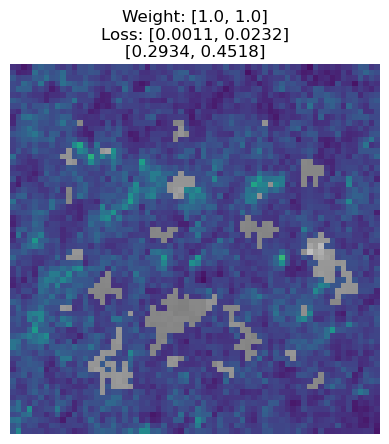

In [28]:
import matplotlib.pyplot as plt
import matplotlib

unique_bool_masks, summed_weights, mean_loss = sum_weights_for_unique_masks(entry['unique_masks_used'], 
                                                                       entry["unique_mask_weights_used"], 
                                                                       entry["unique_losses_used"])

for j in range(len(unique_bool_masks)):
    weight_show = [round(val.item(), 4) for val in summed_weights[j]]
    loss_show = [round(val.item(), 4) for val in mean_loss[j]]
    label_show = [round(val.item(), 4) for val in entry["label"]]
    title = f'Weight: {weight_show}\nLoss: {loss_show}\n{label_show}'
    map_plotter(entry['image'][0].cpu(), unique_bool_masks[j].cpu().numpy(), type='dim')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [29]:
indices

[0]

In [30]:

outputs_avg, outputs, attn_weights1, attn_weights2, pooler_outputs = model(inputs, 
                                                                           segs=masks,
                                                                           mask_batch_size=mask_batch_size, 
                                                                           return_tuple=True)
original_outputs = backbone_model(inputs).logits

preds_wrapped.append(outputs_avg)
preds_original.append(original_outputs)
gold_labels.append(labels)

bsz, num_masks, num_labels = outputs.shape

loss_avg = criterion(outputs_avg, labels)
total_loss_wrapped += loss_avg.sum(0)
loss_original = criterion(original_outputs, labels)
total_loss_original += loss_original.sum(0)
total_count += labels.size(0)
loss = criterion(outputs.reshape(-1, model.config.num_labels), 
                 labels.unsqueeze(1).expand(bsz, 
                                            num_masks, 
                                            num_labels).reshape(-1, num_labels))
loss = loss.reshape(outputs.shape)

i = 0
masks_used = attn_weights1[i][attn_weights2[i].sum(-1).bool()]  # get masks that are used for any class
mask_weights = attn_weights2[i][attn_weights2[i].sum(-1).bool()]
output_used = outputs[i][attn_weights2[i].sum(-1).bool()]
pooler_used = pooler_outputs[i][attn_weights2[i].sum(-1).bool()]
loss_used = loss[i][attn_weights2[i].sum(-1).bool()]

# import pdb
# pdb.set_trace()
unique_masks_used, reverse_indices, counts = torch.unique(masks_used, 
                                                        dim=0, 
                                                        return_inverse=True, 
                                                        return_counts=True)
indices = []
reverse_indices = reverse_indices.cpu().numpy().tolist()

for j in range(len(counts)):
    indices.append(reverse_indices.index(j))
# import pdb
# pdb.set_trace()
unique_mask_weights = mask_weights[indices] * counts.view(-1, 1)
unique_outputs = output_used[indices]
unique_preds = loss_used[indices].tolist()
unique_pooler = pooler_used[indices]

entry = {'image': images[i],
        'outputs_avg': outputs_avg[i],
        'outputs': unique_outputs, # outputs[i]
        'pooler': unique_pooler,
        'outputs_original': original_outputs[i],
        'masks': attn_weights1[i].cpu().numpy(),
        'masks_all': masks_i[i].cpu().numpy() \
            if masks_i is not None \
                else None,
        'masks_used': unique_masks_used,  # masks_used,
        'mask_weights': unique_mask_weights,  # mask_weights,
        'pred': loss_avg[i].tolist(),
        'preds': unique_preds, # predicted_raw[i].tolist(),
        'label': labels[i].tolist(),
        'counts': counts.cpu().numpy(),
        'num_labels': model.config.num_labels}


OutOfMemoryError: CUDA out of memory. Tried to allocate 664.67 GiB (GPU 0; 47.54 GiB total capacity; 1.68 GiB already allocated; 4.89 GiB free; 42.32 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
criterion = nn.MSELoss(reduction='none')

all_results = []

progress_bar = tqdm(range(len(val_dataloader)))
model.eval()
preds_wrapped = []
preds_original = []
gold_labels = []
with torch.no_grad():
    idx = 0
    total_loss_wrapped = 0
    total_loss_original = 0
    total_count = 0
    for batch in val_loader:
        output_filename = os.path.join(output_dirname, f'{idx}.pt')
        if os.path.exists(output_filename):
            progress_bar.update(1)
            idx += 1
            continue
        inputs, labels, masks, masks_i = batch
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        masks = masks.to(device)

        images = inputs.cpu().numpy()

        # images = [Image.fromarray(inputs_numpy[i]) for i in range(inputs_numpy.shape[0])]

        outputs_avg, outputs, attn_weights1, attn_weights2, pooler_outputs = model(inputs, 
                                                                   masks=masks,
                                epoch=model.config.num_heads,
                                mask_batch_size=args.mask_batch_size,
                                return_pooler=True)
        original_outputs = backbone_model(inputs).logits

        preds_wrapped.append(outputs_avg)
        preds_original.append(original_outputs)
        gold_labels.append(labels)

        bsz, num_masks, num_labels = outputs.shape

        loss_avg = criterion(outputs_avg, labels)
        total_loss_wrapped += loss_avg.sum(0)
        loss_original = criterion(original_outputs, labels)
        total_loss_original += loss_original.sum(0)
        total_count += labels.size(0)
        loss = criterion(outputs.reshape(-1, model.config.num_labels), 
                         labels.unsqueeze(1).expand(bsz, 
                                                    num_masks, 
                                                    num_labels).reshape(-1, num_labels))
        loss = loss.reshape(outputs.shape)

        if not args.scatter_only:
            for i in range(len(images)):

                masks_used = attn_weights1[i][attn_weights2[i].sum(-1).bool()]  # get masks that are used for any class
                mask_weights = attn_weights2[i][attn_weights2[i].sum(-1).bool()]
                output_used = outputs[i][attn_weights2[i].sum(-1).bool()]
                pooler_used = pooler_outputs[i][attn_weights2[i].sum(-1).bool()]
                loss_used = loss[i][attn_weights2[i].sum(-1).bool()]

                # import pdb
                # pdb.set_trace()
                unique_masks_used, reverse_indices, counts = torch.unique(masks_used, 
                                                                        dim=0, 
                                                                        return_inverse=True, 
                                                                        return_counts=True)
                indices = []
                reverse_indices = reverse_indices.cpu().numpy().tolist()

                for j in range(len(counts)):
                    indices.append(reverse_indices.index(j))
                # import pdb
                # pdb.set_trace()
                unique_mask_weights = mask_weights[indices] * counts.view(-1, 1)
                unique_outputs = output_used[indices]
                unique_preds = loss_used[indices].tolist()
                unique_pooler = pooler_used[indices]

                entry = {'image': images[i],
                        'outputs_avg': outputs_avg[i],
                        'outputs': unique_outputs, # outputs[i]
                        'pooler': unique_pooler,
                        'outputs_original': original_outputs[i],
                        'masks': attn_weights1[i].cpu().numpy(),
                        'masks_all': masks_i[i].cpu().numpy() \
                            if masks_i is not None \
                                else None,
                        'masks_used': unique_masks_used,  # masks_used,
                        'mask_weights': unique_mask_weights,  # mask_weights,
                        'pred': loss_avg[i].tolist(),
                        'preds': unique_preds, # predicted_raw[i].tolist(),
                        'label': labels[i].tolist(),
                        'counts': counts.cpu().numpy(),
                        'num_labels': model.config.num_labels}

                # print('attn_weights1[i]', attn_weights1[i].shape)
                # print('attn_weights2[i]', attn_weights2[i].shape)

                all_results.append(entry)
                output_filename = os.path.join(output_dirname, f'{idx}.pkl')
                torch.save(entry, output_filename)

        progress_bar.update(1)
        idx += 1

        del images

    preds_wrapped = torch.cat(preds_wrapped).cpu().numpy()
    preds_original = torch.cat(preds_original).cpu().numpy()
    gold_labels = torch.cat(gold_labels).cpu().numpy()

    plot_y = gold_labels
    # predictions = preds
    upp_lims = np.nanmax(plot_y, axis=0)
    low_lims = np.nanmin(plot_y, axis=0)

    # Visualize predictions
    fig, axes = plt.subplots(nrows=1, ncols=len(low_lims), figsize=(20, 10))

    for ind, (low_lim, upp_lim) in enumerate(zip(low_lims, upp_lims)):
        p_w = np.poly1d(np.polyfit(plot_y[:, ind], preds_wrapped[:, ind], 1))
        p_o = np.poly1d(np.polyfit(plot_y[:, ind], preds_original[:, ind], 1))

        axes[ind].scatter(plot_y[:, ind], preds_wrapped[:, ind], color="blue", label='Wrapped')
        axes[ind].scatter(plot_y[:, ind], preds_original[:, ind], color="orange", label='Original')
        axes[ind].plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
        axes[ind].plot([low_lim, upp_lim], [p_w(low_lim), p_w(upp_lim)], color="black", ls=":", label='Wrapped')
        axes[ind].plot([low_lim, upp_lim], [p_o(low_lim), p_o(upp_lim)], color="black", ls="-.", label='Original')
        axes[ind].set_xlim([low_lim, upp_lim])
        axes[ind].set_ylim([low_lim, upp_lim])
        axes[ind].set_xlabel('Gold')
        axes[ind].set_ylabel('Pred')
        axes[ind].legend()
        axes[ind].set_aspect('equal', adjustable='box')

        original_loss = round((total_loss_original / total_count)[ind].cpu().item(), 4)
        wrapped_loss = round((total_loss_wrapped / total_count)[ind].cpu().item(), 4)

        axes[ind].set_title(f'Output {ind}, \n' + 
                            f'Original loss {original_loss},\n' +
                            f'Wrapped loss {wrapped_loss}')

    # plt.tight_layout()
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.9)
    plt.savefig(os.path.join(args.exp_dir, 'combined_scatter.png'))
    plt.close()

    # Visualize predictions
    fig, axes = plt.subplots(nrows=1, ncols=len(low_lims), figsize=(20, 10))

    for ind, (low_lim, upp_lim) in enumerate(zip(low_lims, upp_lims)):
        p_w = np.poly1d(np.polyfit(plot_y[:, ind], preds_wrapped[:, ind], 1))
        p_o = np.poly1d(np.polyfit(plot_y[:, ind], preds_original[:, ind], 1))

        # (Wrapped - Gold) / Gold
        diff_wrapped = (preds_wrapped[:, ind] - plot_y[:, ind]) / plot_y[:, ind]
        # (Original - Gold) / Gold
        diff_original = (preds_original[:, ind] - plot_y[:, ind]) / plot_y[:, ind]
        axes[ind].scatter(plot_y[:, ind], diff_wrapped, color="green", label='Wrapped')
        axes[ind].scatter(plot_y[:, ind], diff_original, color="red", label='Original')
        axes[ind].scatter(plot_y[:, ind], preds_wrapped[:, ind], color="blue", label='Wrapped')
        axes[ind].scatter(plot_y[:, ind], preds_original[:, ind], color="orange", label='Original')
        axes[ind].plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
        axes[ind].plot([low_lim, upp_lim], [p_w(low_lim), p_w(upp_lim)], color="black", ls=":", label='Wrapped')
        axes[ind].plot([low_lim, upp_lim], [p_o(low_lim), p_o(upp_lim)], color="black", ls="-.", label='Original')
        # axes[ind].set_xlim([low_lim, upp_lim])
        # axes[ind].set_ylim([low_lim, upp_lim])
        axes[ind].set_xlabel('Gold')
        axes[ind].set_ylabel('Pred')
        axes[ind].legend()
        axes[ind].set_aspect('equal', adjustable='box')

        original_loss = round((total_loss_original / total_count)[ind].cpu().item(), 4)
        wrapped_loss = round((total_loss_wrapped / total_count)[ind].cpu().item(), 4)

        axes[ind].set_title(f'Output {ind}, \n' + 
                            f'Original loss {original_loss},\n' +
                            f'Wrapped loss {wrapped_loss}')

    # plt.tight_layout()
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.9)
    plt.savefig(os.path.join(args.exp_dir, 'combined_scatter_diff.png'))
    plt.close()

    # Visualize predictions
    fig, axes = plt.subplots(nrows=1, ncols=len(low_lims), figsize=(20, 10))


    for ind, (low_lim, upp_lim) in enumerate(zip(low_lims, upp_lims)):
        p_w = np.poly1d(np.polyfit(plot_y[:, ind], preds_wrapped[:, ind], 1))
        p_o = np.poly1d(np.polyfit(plot_y[:, ind], preds_original[:, ind], 1))

        # (Wrapped - Gold) / Gold
        diff_wrapped = (preds_wrapped[:, ind] - plot_y[:, ind]) / plot_y[:, ind]
        # (Original - Gold) / Gold
        diff_original = (preds_original[:, ind] - plot_y[:, ind]) / plot_y[:, ind]
        axes[ind].scatter(plot_y[:, ind], diff_wrapped, color="blue", label='Wrapped')
        axes[ind].scatter(plot_y[:, ind], diff_original, color="orange", label='Original')
        # axes[ind].plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
        # axes[ind].plot([low_lim, upp_lim], [p_w(low_lim), p_w(upp_lim)], color="black", ls=":", label='Wrapped')
        # axes[ind].plot([low_lim, upp_lim], [p_o(low_lim), p_o(upp_lim)], color="black", ls="-.", label='Original')
        # axes[ind].set_xlim([low_lim, upp_lim])
        # axes[ind].set_ylim([low_lim, upp_lim])
        axes[ind].set_xlabel('Gold')
        axes[ind].set_ylabel('Pred')
        axes[ind].legend()
        axes[ind].set_aspect('equal', adjustable='box')

        original_loss = round((total_loss_original / total_count)[ind].cpu().item(), 4)
        wrapped_loss = round((total_loss_wrapped / total_count)[ind].cpu().item(), 4)

        axes[ind].set_title(f'Output {ind}, \n' + 
                            f'Original loss {original_loss},\n' +
                            f'Wrapped loss {wrapped_loss}')

    # plt.tight_layout()
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.9)
    plt.savefig(os.path.join(args.exp_dir, 'combined_scatter_diff_only.png'))
    plt.close()

    print('mean-center-offset', args.mean_center_offset)
    print('mean-center-scale', args.mean_center_scale)
    print('mean-center-offset2', args.mean_center_offset2)
    print('mean-center-scale2', args.mean_center_scale2)
    print('original_loss', original_loss)
    print('wrapped_loss', wrapped_loss)